In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import plotly.io as pio
pio.renderers.default = 'colab'

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

## 1. Import dataset

In [2]:
data_dir = 'dataset'
### With these commands the train and test datasets, respectively, are downloaded
### automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning:

The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)



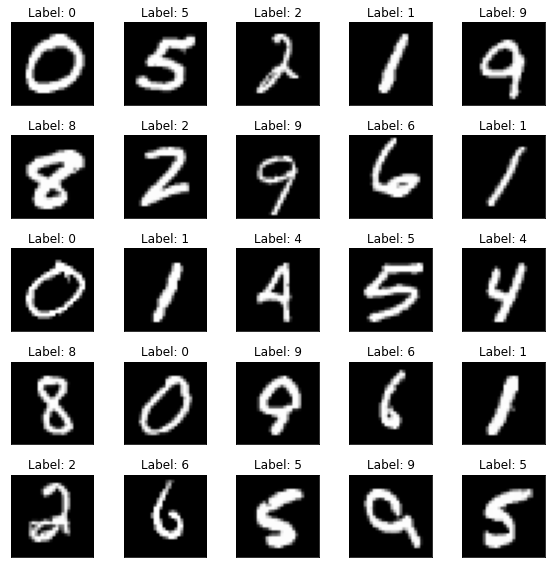

In [3]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [4]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [5]:
m=len(train_dataset)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

## 2. Define Convolutional Autoencoder

In [6]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            #nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [7]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

## 3. Initialize Loss function and the optimizer

In [8]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)

In [9]:
### Some examples
# Take an input image (remember to add the batch dimension)
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image

img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)

# Decode the image
dec_img = decoder(img_enc)
#dec_img = model(img)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 4])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [10]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001
#lr = 0.0008 # Learning rate


params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)
#optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=6e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
#model.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

## 4. Train and evaluate model

In [11]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [12]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [13]:
def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 0.253071
	 partial train loss (single batch): 0.246623
	 partial train loss (single batch): 0.240046
	 partial train loss (single batch): 0.236102
	 partial train loss (single batch): 0.232017
	 partial train loss (single batch): 0.227850
	 partial train loss (single batch): 0.225047
	 partial train loss (single batch): 0.222485
	 partial train loss (single batch): 0.219658
	 partial train loss (single batch): 0.217869
	 partial train loss (single batch): 0.215896
	 partial train loss (single batch): 0.213652
	 partial train loss (single batch): 0.211206
	 partial train loss (single batch): 0.209193
	 partial train loss (single batch): 0.207377
	 partial train loss (single batch): 0.205306
	 partial train loss (single batch): 0.203319
	 partial train loss (single batch): 0.201178
	 partial train loss (single batch): 0.199227
	 partial train loss (single batch): 0.197082
	 partial train loss (single batch): 0.195995
	 partial train loss (single batch

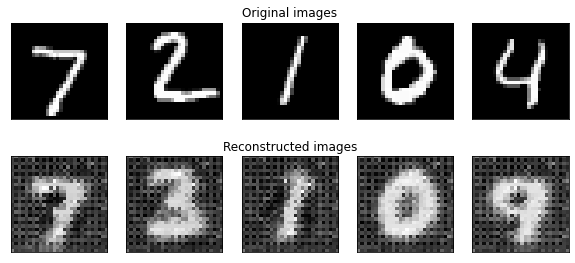

	 partial train loss (single batch): 0.066099
	 partial train loss (single batch): 0.065267
	 partial train loss (single batch): 0.066149
	 partial train loss (single batch): 0.065695
	 partial train loss (single batch): 0.065135
	 partial train loss (single batch): 0.065599
	 partial train loss (single batch): 0.064899
	 partial train loss (single batch): 0.063811
	 partial train loss (single batch): 0.064354
	 partial train loss (single batch): 0.063705
	 partial train loss (single batch): 0.063492
	 partial train loss (single batch): 0.063629
	 partial train loss (single batch): 0.062771
	 partial train loss (single batch): 0.064003
	 partial train loss (single batch): 0.062663
	 partial train loss (single batch): 0.062843
	 partial train loss (single batch): 0.062039
	 partial train loss (single batch): 0.063197
	 partial train loss (single batch): 0.061868
	 partial train loss (single batch): 0.061615
	 partial train loss (single batch): 0.061433
	 partial train loss (single batch

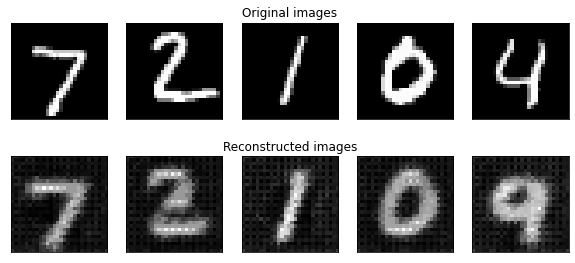

	 partial train loss (single batch): 0.046845
	 partial train loss (single batch): 0.045695
	 partial train loss (single batch): 0.047543
	 partial train loss (single batch): 0.046881
	 partial train loss (single batch): 0.046636
	 partial train loss (single batch): 0.047569
	 partial train loss (single batch): 0.046704
	 partial train loss (single batch): 0.045436
	 partial train loss (single batch): 0.046159
	 partial train loss (single batch): 0.045649
	 partial train loss (single batch): 0.045674
	 partial train loss (single batch): 0.045898
	 partial train loss (single batch): 0.045504
	 partial train loss (single batch): 0.047222
	 partial train loss (single batch): 0.044995
	 partial train loss (single batch): 0.045637
	 partial train loss (single batch): 0.045062
	 partial train loss (single batch): 0.046329
	 partial train loss (single batch): 0.045254
	 partial train loss (single batch): 0.045251
	 partial train loss (single batch): 0.045314
	 partial train loss (single batch

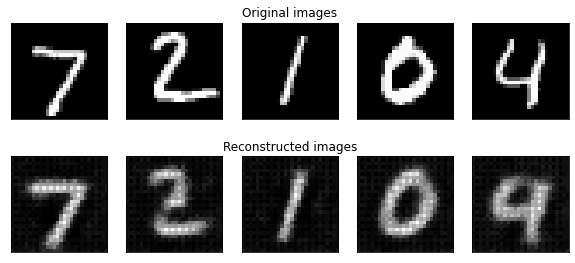

	 partial train loss (single batch): 0.038662
	 partial train loss (single batch): 0.036969
	 partial train loss (single batch): 0.038640
	 partial train loss (single batch): 0.038655
	 partial train loss (single batch): 0.038587
	 partial train loss (single batch): 0.039072
	 partial train loss (single batch): 0.038880
	 partial train loss (single batch): 0.036878
	 partial train loss (single batch): 0.037940
	 partial train loss (single batch): 0.037334
	 partial train loss (single batch): 0.036970
	 partial train loss (single batch): 0.037802
	 partial train loss (single batch): 0.037523
	 partial train loss (single batch): 0.038765
	 partial train loss (single batch): 0.036601
	 partial train loss (single batch): 0.037529
	 partial train loss (single batch): 0.036605
	 partial train loss (single batch): 0.038279
	 partial train loss (single batch): 0.036621
	 partial train loss (single batch): 0.037460
	 partial train loss (single batch): 0.037120
	 partial train loss (single batch

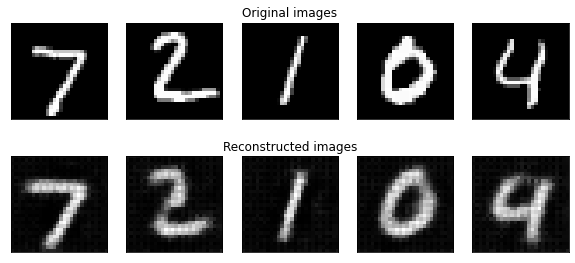

	 partial train loss (single batch): 0.034093
	 partial train loss (single batch): 0.032259
	 partial train loss (single batch): 0.033924
	 partial train loss (single batch): 0.034043
	 partial train loss (single batch): 0.034375
	 partial train loss (single batch): 0.034684
	 partial train loss (single batch): 0.035007
	 partial train loss (single batch): 0.032434
	 partial train loss (single batch): 0.033807
	 partial train loss (single batch): 0.033212
	 partial train loss (single batch): 0.032443
	 partial train loss (single batch): 0.033474
	 partial train loss (single batch): 0.033657
	 partial train loss (single batch): 0.034432
	 partial train loss (single batch): 0.032324
	 partial train loss (single batch): 0.033414
	 partial train loss (single batch): 0.032565
	 partial train loss (single batch): 0.034073
	 partial train loss (single batch): 0.032285
	 partial train loss (single batch): 0.033747
	 partial train loss (single batch): 0.033271
	 partial train loss (single batch

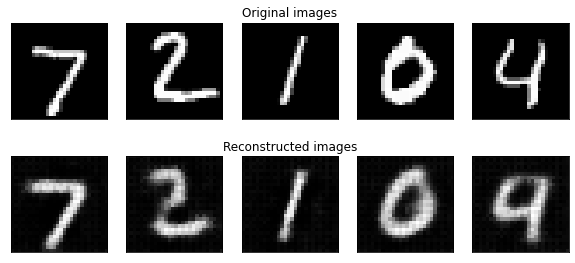

	 partial train loss (single batch): 0.032017
	 partial train loss (single batch): 0.030111
	 partial train loss (single batch): 0.031971
	 partial train loss (single batch): 0.032126
	 partial train loss (single batch): 0.032220
	 partial train loss (single batch): 0.032734
	 partial train loss (single batch): 0.033093
	 partial train loss (single batch): 0.030521
	 partial train loss (single batch): 0.032011
	 partial train loss (single batch): 0.031456
	 partial train loss (single batch): 0.030257
	 partial train loss (single batch): 0.031536
	 partial train loss (single batch): 0.031813
	 partial train loss (single batch): 0.032493
	 partial train loss (single batch): 0.030560
	 partial train loss (single batch): 0.031432
	 partial train loss (single batch): 0.030756
	 partial train loss (single batch): 0.032161
	 partial train loss (single batch): 0.030339
	 partial train loss (single batch): 0.032138
	 partial train loss (single batch): 0.031438
	 partial train loss (single batch

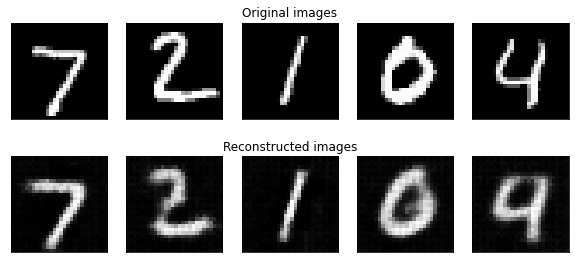

	 partial train loss (single batch): 0.030837
	 partial train loss (single batch): 0.028868
	 partial train loss (single batch): 0.030838
	 partial train loss (single batch): 0.030997
	 partial train loss (single batch): 0.031048
	 partial train loss (single batch): 0.031425
	 partial train loss (single batch): 0.032092
	 partial train loss (single batch): 0.029425
	 partial train loss (single batch): 0.030839
	 partial train loss (single batch): 0.030443
	 partial train loss (single batch): 0.029139
	 partial train loss (single batch): 0.030369
	 partial train loss (single batch): 0.030774
	 partial train loss (single batch): 0.031489
	 partial train loss (single batch): 0.029531
	 partial train loss (single batch): 0.030367
	 partial train loss (single batch): 0.029699
	 partial train loss (single batch): 0.031025
	 partial train loss (single batch): 0.029209
	 partial train loss (single batch): 0.031182
	 partial train loss (single batch): 0.030381
	 partial train loss (single batch

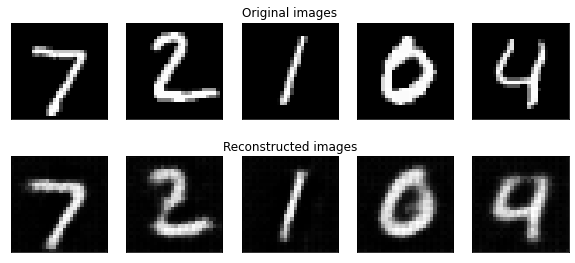

	 partial train loss (single batch): 0.030083
	 partial train loss (single batch): 0.028042
	 partial train loss (single batch): 0.030064
	 partial train loss (single batch): 0.030341
	 partial train loss (single batch): 0.030322
	 partial train loss (single batch): 0.030500
	 partial train loss (single batch): 0.031361
	 partial train loss (single batch): 0.028785
	 partial train loss (single batch): 0.030124
	 partial train loss (single batch): 0.029947
	 partial train loss (single batch): 0.028482
	 partial train loss (single batch): 0.029676
	 partial train loss (single batch): 0.030033
	 partial train loss (single batch): 0.030777
	 partial train loss (single batch): 0.028848
	 partial train loss (single batch): 0.029680
	 partial train loss (single batch): 0.028959
	 partial train loss (single batch): 0.030211
	 partial train loss (single batch): 0.028369
	 partial train loss (single batch): 0.030572
	 partial train loss (single batch): 0.029741
	 partial train loss (single batch

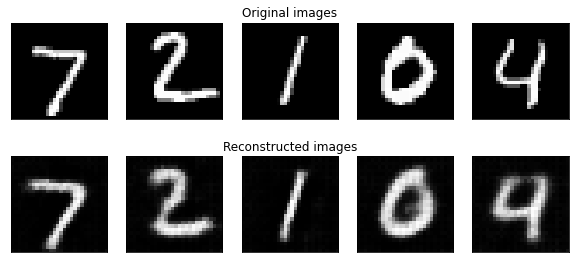

	 partial train loss (single batch): 0.029728
	 partial train loss (single batch): 0.027518
	 partial train loss (single batch): 0.029714
	 partial train loss (single batch): 0.029885
	 partial train loss (single batch): 0.029778
	 partial train loss (single batch): 0.029936
	 partial train loss (single batch): 0.030808
	 partial train loss (single batch): 0.028334
	 partial train loss (single batch): 0.029618
	 partial train loss (single batch): 0.029408
	 partial train loss (single batch): 0.028005
	 partial train loss (single batch): 0.029207
	 partial train loss (single batch): 0.029392
	 partial train loss (single batch): 0.030338
	 partial train loss (single batch): 0.028372
	 partial train loss (single batch): 0.029212
	 partial train loss (single batch): 0.028334
	 partial train loss (single batch): 0.029649
	 partial train loss (single batch): 0.027753
	 partial train loss (single batch): 0.029935
	 partial train loss (single batch): 0.029243
	 partial train loss (single batch

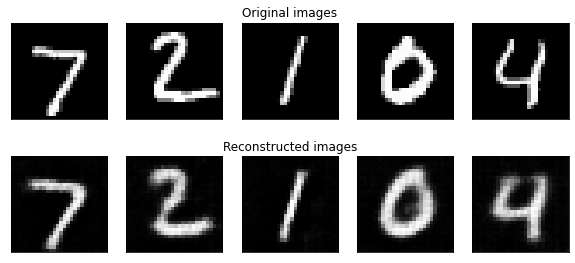

	 partial train loss (single batch): 0.029355
	 partial train loss (single batch): 0.027159
	 partial train loss (single batch): 0.029417
	 partial train loss (single batch): 0.029586
	 partial train loss (single batch): 0.029327
	 partial train loss (single batch): 0.029482
	 partial train loss (single batch): 0.030419
	 partial train loss (single batch): 0.028067
	 partial train loss (single batch): 0.029237
	 partial train loss (single batch): 0.029068
	 partial train loss (single batch): 0.027600
	 partial train loss (single batch): 0.028778
	 partial train loss (single batch): 0.028945
	 partial train loss (single batch): 0.029887
	 partial train loss (single batch): 0.027862
	 partial train loss (single batch): 0.028815
	 partial train loss (single batch): 0.027946
	 partial train loss (single batch): 0.029224
	 partial train loss (single batch): 0.027324
	 partial train loss (single batch): 0.029549
	 partial train loss (single batch): 0.028873
	 partial train loss (single batch

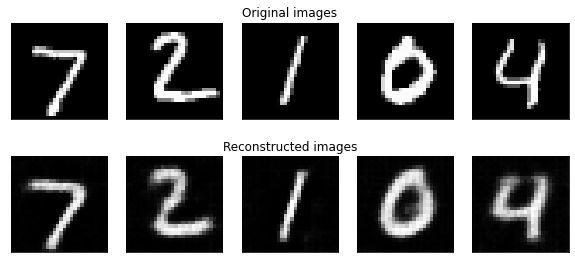

	 partial train loss (single batch): 0.028959
	 partial train loss (single batch): 0.026794
	 partial train loss (single batch): 0.028989
	 partial train loss (single batch): 0.029302
	 partial train loss (single batch): 0.028835
	 partial train loss (single batch): 0.029037
	 partial train loss (single batch): 0.030124
	 partial train loss (single batch): 0.027873
	 partial train loss (single batch): 0.028995
	 partial train loss (single batch): 0.028755
	 partial train loss (single batch): 0.027125
	 partial train loss (single batch): 0.028371
	 partial train loss (single batch): 0.028499
	 partial train loss (single batch): 0.029436
	 partial train loss (single batch): 0.027586
	 partial train loss (single batch): 0.028436
	 partial train loss (single batch): 0.027598
	 partial train loss (single batch): 0.028821
	 partial train loss (single batch): 0.026949
	 partial train loss (single batch): 0.029167
	 partial train loss (single batch): 0.028542
	 partial train loss (single batch

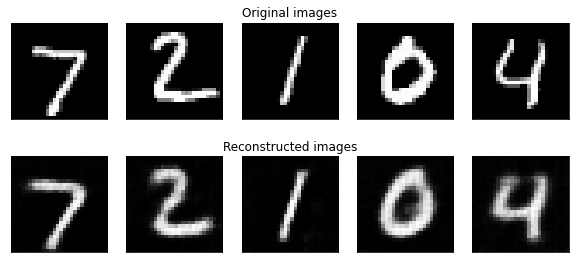

	 partial train loss (single batch): 0.028629
	 partial train loss (single batch): 0.026550
	 partial train loss (single batch): 0.028747
	 partial train loss (single batch): 0.029031
	 partial train loss (single batch): 0.028604
	 partial train loss (single batch): 0.028711
	 partial train loss (single batch): 0.029844
	 partial train loss (single batch): 0.027669
	 partial train loss (single batch): 0.028744
	 partial train loss (single batch): 0.028519
	 partial train loss (single batch): 0.026849
	 partial train loss (single batch): 0.028006
	 partial train loss (single batch): 0.028249
	 partial train loss (single batch): 0.029122
	 partial train loss (single batch): 0.027326
	 partial train loss (single batch): 0.028152
	 partial train loss (single batch): 0.027267
	 partial train loss (single batch): 0.028648
	 partial train loss (single batch): 0.026583
	 partial train loss (single batch): 0.028810
	 partial train loss (single batch): 0.028290
	 partial train loss (single batch

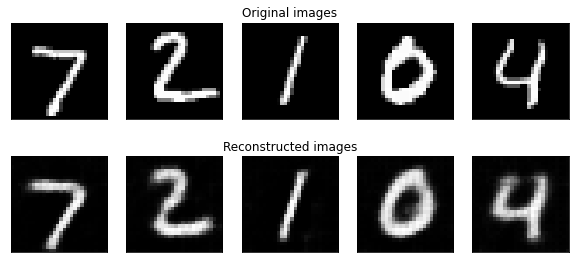

	 partial train loss (single batch): 0.028367
	 partial train loss (single batch): 0.026340
	 partial train loss (single batch): 0.028464
	 partial train loss (single batch): 0.028730
	 partial train loss (single batch): 0.028358
	 partial train loss (single batch): 0.028390
	 partial train loss (single batch): 0.029621
	 partial train loss (single batch): 0.027512
	 partial train loss (single batch): 0.028446
	 partial train loss (single batch): 0.028234
	 partial train loss (single batch): 0.026520
	 partial train loss (single batch): 0.027824
	 partial train loss (single batch): 0.028066
	 partial train loss (single batch): 0.028983
	 partial train loss (single batch): 0.027160
	 partial train loss (single batch): 0.027963
	 partial train loss (single batch): 0.027024
	 partial train loss (single batch): 0.028396
	 partial train loss (single batch): 0.026313
	 partial train loss (single batch): 0.028586
	 partial train loss (single batch): 0.028133
	 partial train loss (single batch

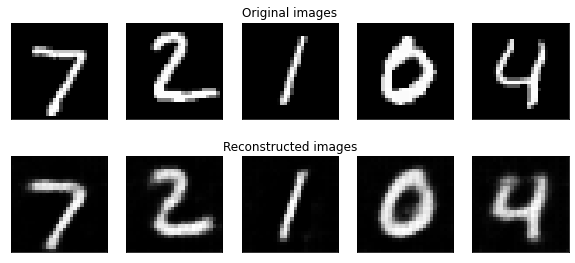

	 partial train loss (single batch): 0.028154
	 partial train loss (single batch): 0.026094
	 partial train loss (single batch): 0.028194
	 partial train loss (single batch): 0.028479
	 partial train loss (single batch): 0.028183
	 partial train loss (single batch): 0.028177
	 partial train loss (single batch): 0.029367
	 partial train loss (single batch): 0.027275
	 partial train loss (single batch): 0.028236
	 partial train loss (single batch): 0.028043
	 partial train loss (single batch): 0.026272
	 partial train loss (single batch): 0.027591
	 partial train loss (single batch): 0.027800
	 partial train loss (single batch): 0.028719
	 partial train loss (single batch): 0.026937
	 partial train loss (single batch): 0.027741
	 partial train loss (single batch): 0.026807
	 partial train loss (single batch): 0.028164
	 partial train loss (single batch): 0.026069
	 partial train loss (single batch): 0.028450
	 partial train loss (single batch): 0.027983
	 partial train loss (single batch

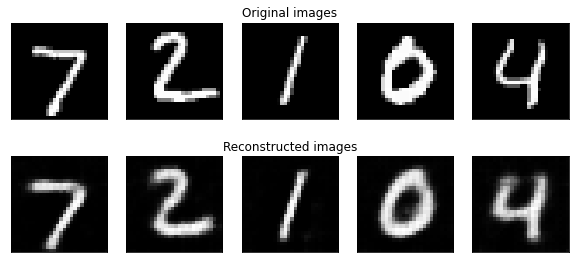

	 partial train loss (single batch): 0.027927
	 partial train loss (single batch): 0.025927
	 partial train loss (single batch): 0.028101
	 partial train loss (single batch): 0.028298
	 partial train loss (single batch): 0.028056
	 partial train loss (single batch): 0.027976
	 partial train loss (single batch): 0.029121
	 partial train loss (single batch): 0.027159
	 partial train loss (single batch): 0.028171
	 partial train loss (single batch): 0.027830
	 partial train loss (single batch): 0.026027
	 partial train loss (single batch): 0.027393
	 partial train loss (single batch): 0.027686
	 partial train loss (single batch): 0.028526
	 partial train loss (single batch): 0.026717
	 partial train loss (single batch): 0.027670
	 partial train loss (single batch): 0.026684
	 partial train loss (single batch): 0.027980
	 partial train loss (single batch): 0.025997
	 partial train loss (single batch): 0.028293
	 partial train loss (single batch): 0.027824
	 partial train loss (single batch

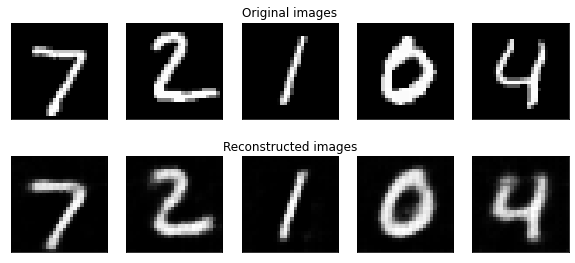

	 partial train loss (single batch): 0.027750
	 partial train loss (single batch): 0.025756
	 partial train loss (single batch): 0.027925
	 partial train loss (single batch): 0.028165
	 partial train loss (single batch): 0.027773
	 partial train loss (single batch): 0.027813
	 partial train loss (single batch): 0.028909
	 partial train loss (single batch): 0.026919
	 partial train loss (single batch): 0.028015
	 partial train loss (single batch): 0.027614
	 partial train loss (single batch): 0.025830
	 partial train loss (single batch): 0.027216
	 partial train loss (single batch): 0.027421
	 partial train loss (single batch): 0.028357
	 partial train loss (single batch): 0.026644
	 partial train loss (single batch): 0.027512
	 partial train loss (single batch): 0.026538
	 partial train loss (single batch): 0.027838
	 partial train loss (single batch): 0.025865
	 partial train loss (single batch): 0.028167
	 partial train loss (single batch): 0.027684
	 partial train loss (single batch

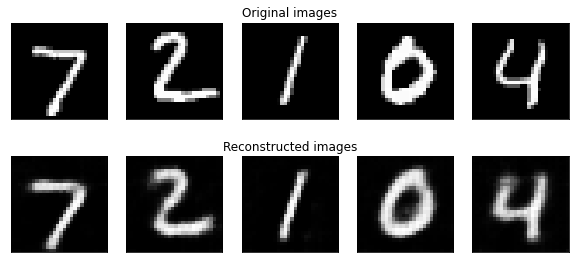

	 partial train loss (single batch): 0.027604
	 partial train loss (single batch): 0.025615
	 partial train loss (single batch): 0.027783
	 partial train loss (single batch): 0.028029
	 partial train loss (single batch): 0.027683
	 partial train loss (single batch): 0.027769
	 partial train loss (single batch): 0.028741
	 partial train loss (single batch): 0.026825
	 partial train loss (single batch): 0.027909
	 partial train loss (single batch): 0.027512
	 partial train loss (single batch): 0.025750
	 partial train loss (single batch): 0.027006
	 partial train loss (single batch): 0.027236
	 partial train loss (single batch): 0.028172
	 partial train loss (single batch): 0.026524
	 partial train loss (single batch): 0.027376
	 partial train loss (single batch): 0.026389
	 partial train loss (single batch): 0.027610
	 partial train loss (single batch): 0.025680
	 partial train loss (single batch): 0.028165
	 partial train loss (single batch): 0.027441
	 partial train loss (single batch

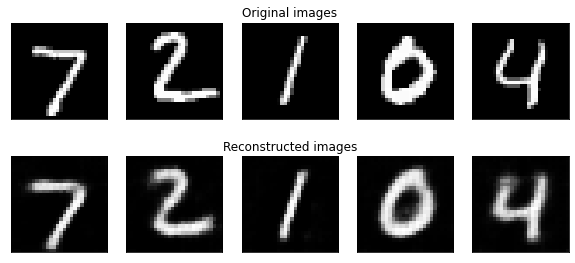

	 partial train loss (single batch): 0.027518
	 partial train loss (single batch): 0.025480
	 partial train loss (single batch): 0.027648
	 partial train loss (single batch): 0.027863
	 partial train loss (single batch): 0.027543
	 partial train loss (single batch): 0.027635
	 partial train loss (single batch): 0.028569
	 partial train loss (single batch): 0.026665
	 partial train loss (single batch): 0.027783
	 partial train loss (single batch): 0.027339
	 partial train loss (single batch): 0.025579
	 partial train loss (single batch): 0.026840
	 partial train loss (single batch): 0.027042
	 partial train loss (single batch): 0.027980
	 partial train loss (single batch): 0.026376
	 partial train loss (single batch): 0.027228
	 partial train loss (single batch): 0.026329
	 partial train loss (single batch): 0.027400
	 partial train loss (single batch): 0.025563
	 partial train loss (single batch): 0.028041
	 partial train loss (single batch): 0.027311
	 partial train loss (single batch

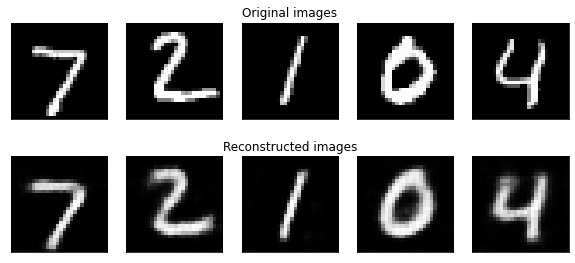

	 partial train loss (single batch): 0.027423
	 partial train loss (single batch): 0.025379
	 partial train loss (single batch): 0.027527
	 partial train loss (single batch): 0.027722
	 partial train loss (single batch): 0.027430
	 partial train loss (single batch): 0.027545
	 partial train loss (single batch): 0.028485
	 partial train loss (single batch): 0.026556
	 partial train loss (single batch): 0.027571
	 partial train loss (single batch): 0.027271
	 partial train loss (single batch): 0.025503
	 partial train loss (single batch): 0.026783
	 partial train loss (single batch): 0.026947
	 partial train loss (single batch): 0.027770
	 partial train loss (single batch): 0.026292
	 partial train loss (single batch): 0.027145
	 partial train loss (single batch): 0.026238
	 partial train loss (single batch): 0.027314
	 partial train loss (single batch): 0.025451
	 partial train loss (single batch): 0.027918
	 partial train loss (single batch): 0.027213
	 partial train loss (single batch

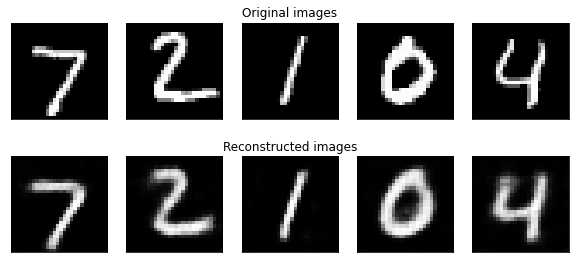

	 partial train loss (single batch): 0.027268
	 partial train loss (single batch): 0.025240
	 partial train loss (single batch): 0.027412
	 partial train loss (single batch): 0.027634
	 partial train loss (single batch): 0.027313
	 partial train loss (single batch): 0.027466
	 partial train loss (single batch): 0.028278
	 partial train loss (single batch): 0.026458
	 partial train loss (single batch): 0.027495
	 partial train loss (single batch): 0.027150
	 partial train loss (single batch): 0.025424
	 partial train loss (single batch): 0.026655
	 partial train loss (single batch): 0.026766
	 partial train loss (single batch): 0.027630
	 partial train loss (single batch): 0.026233
	 partial train loss (single batch): 0.027078
	 partial train loss (single batch): 0.026111
	 partial train loss (single batch): 0.027195
	 partial train loss (single batch): 0.025342
	 partial train loss (single batch): 0.027863
	 partial train loss (single batch): 0.027075
	 partial train loss (single batch

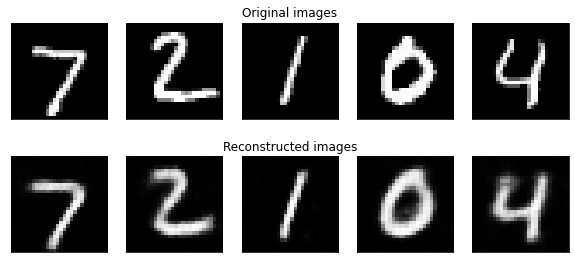

	 partial train loss (single batch): 0.027099
	 partial train loss (single batch): 0.025116
	 partial train loss (single batch): 0.027312
	 partial train loss (single batch): 0.027510
	 partial train loss (single batch): 0.027148
	 partial train loss (single batch): 0.027337
	 partial train loss (single batch): 0.028222
	 partial train loss (single batch): 0.026335
	 partial train loss (single batch): 0.027411
	 partial train loss (single batch): 0.027037
	 partial train loss (single batch): 0.025310
	 partial train loss (single batch): 0.026559
	 partial train loss (single batch): 0.026593
	 partial train loss (single batch): 0.027468
	 partial train loss (single batch): 0.026117
	 partial train loss (single batch): 0.026886
	 partial train loss (single batch): 0.025918
	 partial train loss (single batch): 0.027126
	 partial train loss (single batch): 0.025193
	 partial train loss (single batch): 0.027666
	 partial train loss (single batch): 0.026919
	 partial train loss (single batch

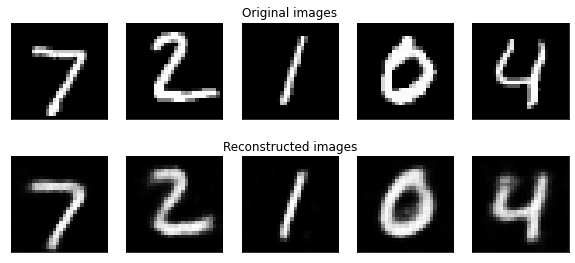

	 partial train loss (single batch): 0.027009
	 partial train loss (single batch): 0.024947
	 partial train loss (single batch): 0.027194
	 partial train loss (single batch): 0.027343
	 partial train loss (single batch): 0.027042
	 partial train loss (single batch): 0.027201
	 partial train loss (single batch): 0.028024
	 partial train loss (single batch): 0.026247
	 partial train loss (single batch): 0.027283
	 partial train loss (single batch): 0.026921
	 partial train loss (single batch): 0.025069
	 partial train loss (single batch): 0.026425
	 partial train loss (single batch): 0.026496
	 partial train loss (single batch): 0.027340
	 partial train loss (single batch): 0.026015
	 partial train loss (single batch): 0.026807
	 partial train loss (single batch): 0.025827
	 partial train loss (single batch): 0.027003
	 partial train loss (single batch): 0.025068
	 partial train loss (single batch): 0.027590
	 partial train loss (single batch): 0.026776
	 partial train loss (single batch

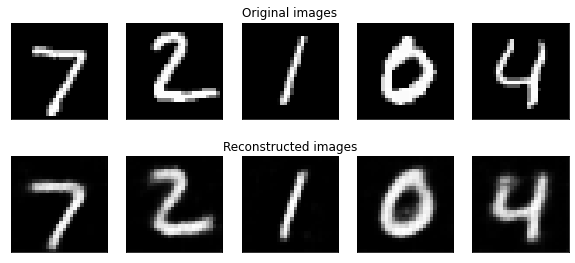

	 partial train loss (single batch): 0.026919
	 partial train loss (single batch): 0.024923
	 partial train loss (single batch): 0.027075
	 partial train loss (single batch): 0.027260
	 partial train loss (single batch): 0.026929
	 partial train loss (single batch): 0.027132
	 partial train loss (single batch): 0.027962
	 partial train loss (single batch): 0.026074
	 partial train loss (single batch): 0.027238
	 partial train loss (single batch): 0.026896
	 partial train loss (single batch): 0.024984
	 partial train loss (single batch): 0.026303
	 partial train loss (single batch): 0.026386
	 partial train loss (single batch): 0.027175
	 partial train loss (single batch): 0.025908
	 partial train loss (single batch): 0.026703
	 partial train loss (single batch): 0.025763
	 partial train loss (single batch): 0.026974
	 partial train loss (single batch): 0.024978
	 partial train loss (single batch): 0.027513
	 partial train loss (single batch): 0.026688
	 partial train loss (single batch

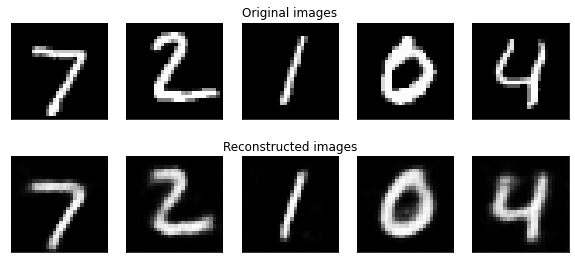

	 partial train loss (single batch): 0.026915
	 partial train loss (single batch): 0.024790
	 partial train loss (single batch): 0.027007
	 partial train loss (single batch): 0.027166
	 partial train loss (single batch): 0.026840
	 partial train loss (single batch): 0.027081
	 partial train loss (single batch): 0.027839
	 partial train loss (single batch): 0.025966
	 partial train loss (single batch): 0.027147
	 partial train loss (single batch): 0.026819
	 partial train loss (single batch): 0.024871
	 partial train loss (single batch): 0.026192
	 partial train loss (single batch): 0.026264
	 partial train loss (single batch): 0.027120
	 partial train loss (single batch): 0.025812
	 partial train loss (single batch): 0.026563
	 partial train loss (single batch): 0.025663
	 partial train loss (single batch): 0.026799
	 partial train loss (single batch): 0.024929
	 partial train loss (single batch): 0.027405
	 partial train loss (single batch): 0.026619
	 partial train loss (single batch

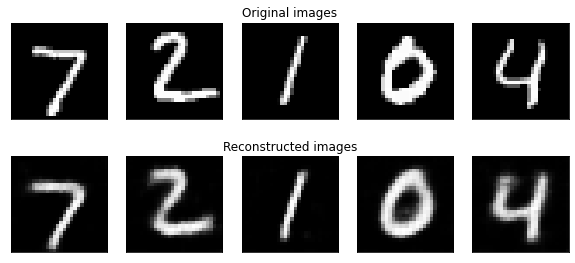

	 partial train loss (single batch): 0.026798
	 partial train loss (single batch): 0.024761
	 partial train loss (single batch): 0.026926
	 partial train loss (single batch): 0.027065
	 partial train loss (single batch): 0.026781
	 partial train loss (single batch): 0.027038
	 partial train loss (single batch): 0.027811
	 partial train loss (single batch): 0.025898
	 partial train loss (single batch): 0.027174
	 partial train loss (single batch): 0.026726
	 partial train loss (single batch): 0.024835
	 partial train loss (single batch): 0.026114
	 partial train loss (single batch): 0.026221
	 partial train loss (single batch): 0.027056
	 partial train loss (single batch): 0.025676
	 partial train loss (single batch): 0.026499
	 partial train loss (single batch): 0.025558
	 partial train loss (single batch): 0.026700
	 partial train loss (single batch): 0.024846
	 partial train loss (single batch): 0.027335
	 partial train loss (single batch): 0.026553
	 partial train loss (single batch

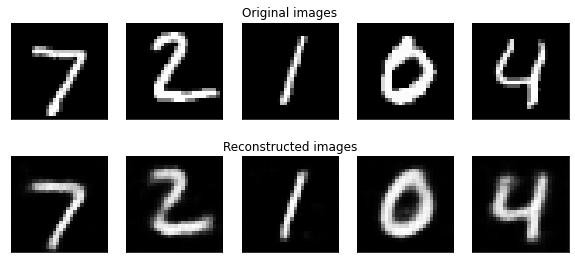

	 partial train loss (single batch): 0.026763
	 partial train loss (single batch): 0.024653
	 partial train loss (single batch): 0.026825
	 partial train loss (single batch): 0.027024
	 partial train loss (single batch): 0.026653
	 partial train loss (single batch): 0.026924
	 partial train loss (single batch): 0.027705
	 partial train loss (single batch): 0.025753
	 partial train loss (single batch): 0.027121
	 partial train loss (single batch): 0.026705
	 partial train loss (single batch): 0.024733
	 partial train loss (single batch): 0.026085
	 partial train loss (single batch): 0.026116
	 partial train loss (single batch): 0.026945
	 partial train loss (single batch): 0.025667
	 partial train loss (single batch): 0.026512
	 partial train loss (single batch): 0.025461
	 partial train loss (single batch): 0.026619
	 partial train loss (single batch): 0.024761
	 partial train loss (single batch): 0.027228
	 partial train loss (single batch): 0.026454
	 partial train loss (single batch

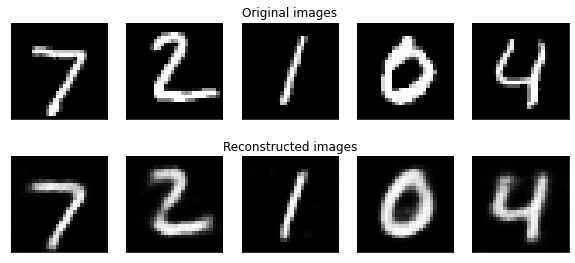

	 partial train loss (single batch): 0.026670
	 partial train loss (single batch): 0.024572
	 partial train loss (single batch): 0.026697
	 partial train loss (single batch): 0.026874
	 partial train loss (single batch): 0.026557
	 partial train loss (single batch): 0.026848
	 partial train loss (single batch): 0.027593
	 partial train loss (single batch): 0.025669
	 partial train loss (single batch): 0.026998
	 partial train loss (single batch): 0.026664
	 partial train loss (single batch): 0.024627
	 partial train loss (single batch): 0.025944
	 partial train loss (single batch): 0.026089
	 partial train loss (single batch): 0.026869
	 partial train loss (single batch): 0.025530
	 partial train loss (single batch): 0.026390
	 partial train loss (single batch): 0.025398
	 partial train loss (single batch): 0.026519
	 partial train loss (single batch): 0.024766
	 partial train loss (single batch): 0.027136
	 partial train loss (single batch): 0.026322
	 partial train loss (single batch

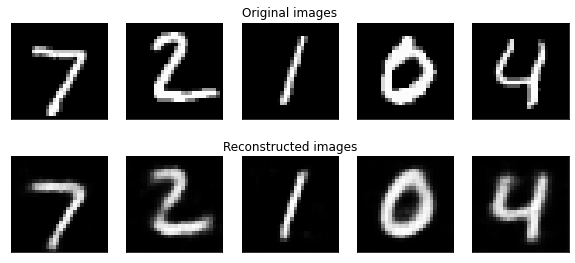

	 partial train loss (single batch): 0.026645
	 partial train loss (single batch): 0.024439
	 partial train loss (single batch): 0.026601
	 partial train loss (single batch): 0.026826
	 partial train loss (single batch): 0.026556
	 partial train loss (single batch): 0.026795
	 partial train loss (single batch): 0.027546
	 partial train loss (single batch): 0.025634
	 partial train loss (single batch): 0.026968
	 partial train loss (single batch): 0.026577
	 partial train loss (single batch): 0.024551
	 partial train loss (single batch): 0.025845
	 partial train loss (single batch): 0.025994
	 partial train loss (single batch): 0.026773
	 partial train loss (single batch): 0.025504
	 partial train loss (single batch): 0.026299
	 partial train loss (single batch): 0.025369
	 partial train loss (single batch): 0.026454
	 partial train loss (single batch): 0.024645
	 partial train loss (single batch): 0.027068
	 partial train loss (single batch): 0.026270
	 partial train loss (single batch

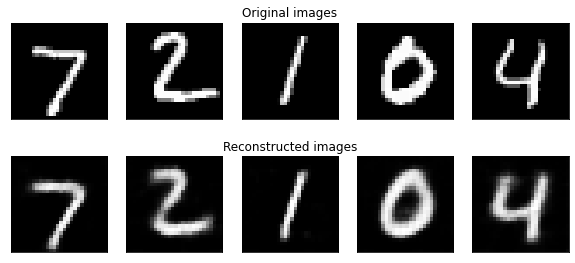

	 partial train loss (single batch): 0.026592
	 partial train loss (single batch): 0.024367
	 partial train loss (single batch): 0.026580
	 partial train loss (single batch): 0.026800
	 partial train loss (single batch): 0.026481
	 partial train loss (single batch): 0.026703
	 partial train loss (single batch): 0.027501
	 partial train loss (single batch): 0.025589
	 partial train loss (single batch): 0.026914
	 partial train loss (single batch): 0.026530
	 partial train loss (single batch): 0.024493
	 partial train loss (single batch): 0.025793
	 partial train loss (single batch): 0.025950
	 partial train loss (single batch): 0.026713
	 partial train loss (single batch): 0.025410
	 partial train loss (single batch): 0.026266
	 partial train loss (single batch): 0.025255
	 partial train loss (single batch): 0.026317
	 partial train loss (single batch): 0.024595
	 partial train loss (single batch): 0.027014
	 partial train loss (single batch): 0.026186
	 partial train loss (single batch

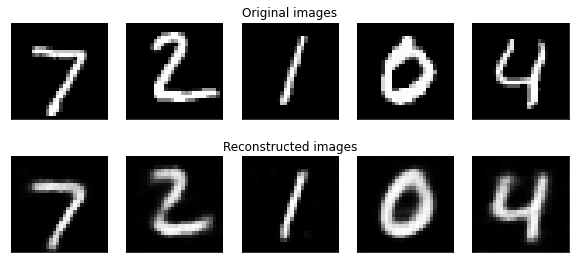

	 partial train loss (single batch): 0.026578
	 partial train loss (single batch): 0.024303
	 partial train loss (single batch): 0.026437
	 partial train loss (single batch): 0.026713
	 partial train loss (single batch): 0.026494
	 partial train loss (single batch): 0.026662
	 partial train loss (single batch): 0.027503
	 partial train loss (single batch): 0.025526
	 partial train loss (single batch): 0.026806
	 partial train loss (single batch): 0.026416
	 partial train loss (single batch): 0.024421
	 partial train loss (single batch): 0.025679
	 partial train loss (single batch): 0.025941
	 partial train loss (single batch): 0.026662
	 partial train loss (single batch): 0.025394
	 partial train loss (single batch): 0.026207
	 partial train loss (single batch): 0.025189
	 partial train loss (single batch): 0.026229
	 partial train loss (single batch): 0.024566
	 partial train loss (single batch): 0.026933
	 partial train loss (single batch): 0.026209
	 partial train loss (single batch

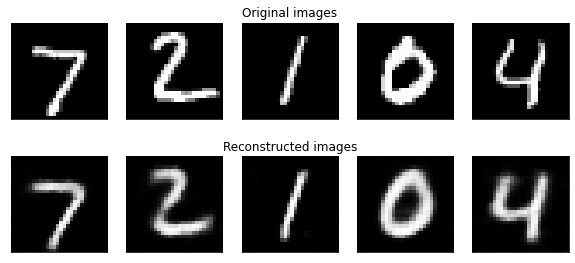

In [14]:
num_epochs = 30
history={'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):

   train_loss = train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,valid_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   history['train_loss'].append(train_loss)
   history['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=5)

In [15]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.026823632419109344

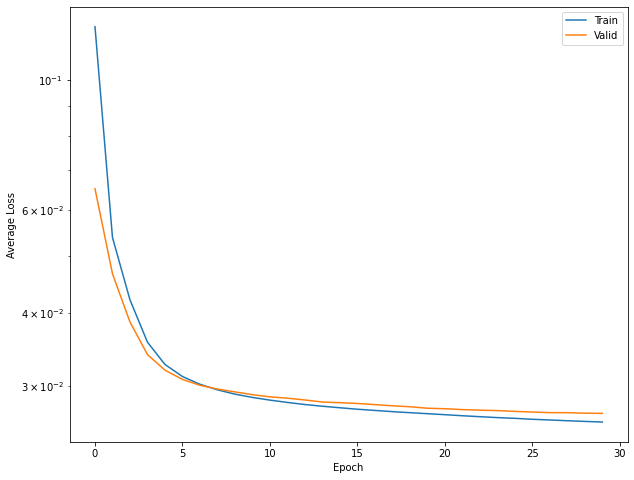

In [16]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(history['train_loss'], label='Train')
plt.semilogy(history['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

## 5. Generate new samples from the latent code

In [17]:
def plot_reconstructed(decoder, r0=(-5, 10), r1=(-10, 5), n=10):
    plt.figure(figsize=(20,8.5))
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')

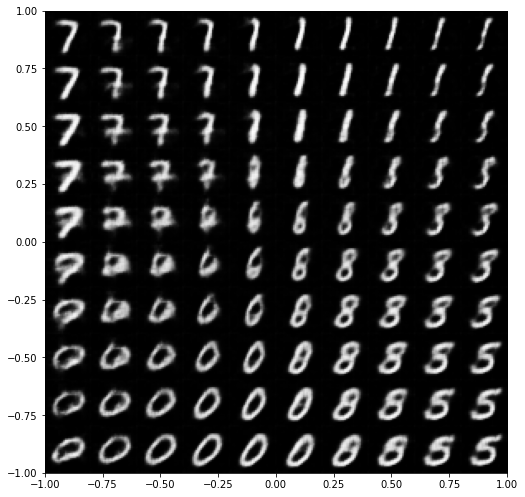

In [18]:
plot_reconstructed(decoder, r0=(-1, 1), r1=(-1, 1))

## 6. Visualize Latent Code 

In [19]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:09<00:00, 1022.08it/s]


In [20]:
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,label
0,-2.268883,1.364354,-0.324822,0.579734,7
1,0.454310,0.688136,1.843909,0.363326,2
2,0.228852,1.283970,-0.108525,0.698502,1
3,-0.180028,-0.964370,0.466799,-0.232247,0
4,-0.556886,-0.119552,-0.489528,-0.667211,4
...,...,...,...,...,...
9995,-0.898000,0.782184,2.056643,1.685823,2
9996,0.931687,0.013393,1.044017,-0.456957,3
9997,-0.570510,0.108823,-0.769197,0.052889,4
9998,0.876379,-0.858239,-1.020191,0.321995,5


In [21]:
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

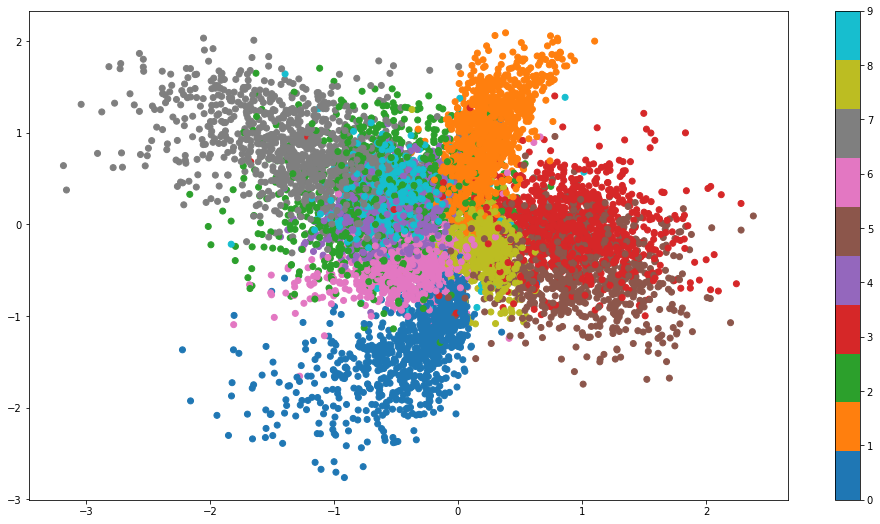

In [22]:
plt.figure(figsize=(17, 9))
plt.scatter(encoded_samples['Enc. Variable 0'], encoded_samples['Enc. Variable 1'], c=encoded_samples.label, cmap='tab10')
plt.colorbar()
plt.show()

In [23]:
pca = PCA(n_components=2)
components = pca.fit_transform(encoded_samples.drop(['label'],axis=1))
total_var = pca.explained_variance_ratio_.sum() * 100
print(total_var)

62.58848624383147


In [24]:
fig = px.scatter(components, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'PC 1', '1': 'PC 2'})
fig.show()

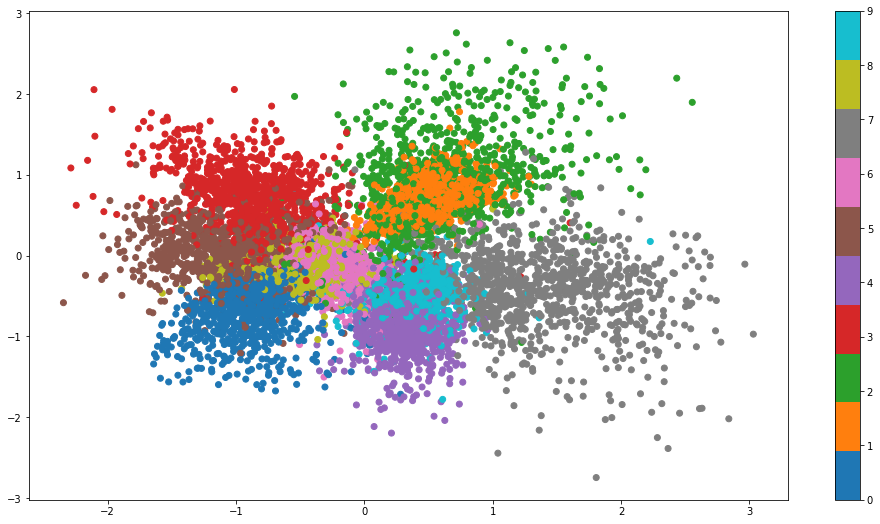

In [25]:
plt.figure(figsize=(17, 9))
plt.scatter(components[:,0], components[:,1], c=encoded_samples.label, cmap='tab10')
plt.colorbar()
plt.show()

In [26]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

In [27]:
fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

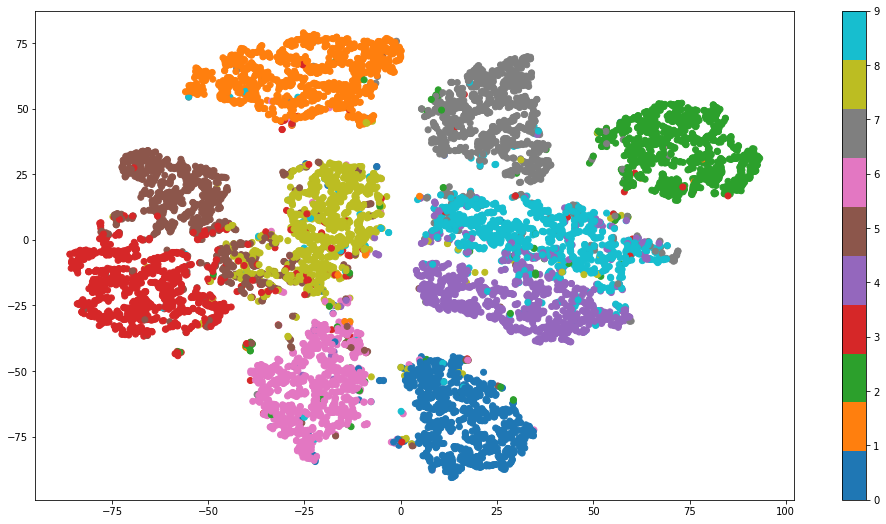

In [28]:
plt.figure(figsize=(17, 9))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=encoded_samples.label, cmap='tab10')
plt.colorbar()
plt.show()